In [1]:
import nltk
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download the stopwords
nltk.download('stopwords')

/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcastells/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# AnnData structure

| Composant   | Type                      | Dimensions               | Contenu                  | Exemple                         |
| ----------- | ------------------------- | ------------------------ | ------------------------ | ------------------------------- |
| **`.X`**    | matrice (dense ou sparse) | n_cells × n_genes        | Expression génique       | log1p(counts)                   |
| **`.obs`**  | DataFrame                 | n_cells × n_obs_features | Infos sur chaque cellule | clusters, n_genes, percent_mito |
| **`.var`**  | DataFrame                 | n_genes × n_var_features | Infos sur chaque gène    | gene_name, hvgs                 |
| **`.obsm`** | dict de matrices          | (ex : n_cells × 2)       | Embeddings cellulaires   | PCA, UMAP                       |
| **`.varm`** | dict de matrices          | (ex : n_genes × 50)      | Embeddings géniques      | loadings PCA                    |
| **`.uns`**  | dict                      | –                        | Données non structurées  | couleurs, graphes, paramètres   |


## Similarity scRNA-Seq data / 20NewsGroup

| Column single-cell | Column text | Description                                      |
| --------------------------- | -------------------- | ------------------------------------------------ |
| **n_genes**                 | `n_words`            | number of words in the document                 |
| **percent_mito**            | `percent_stopwords`  | stopwords percentage                         |
| **n_counts**                | `n_chars`            | number of chars                       |
| **louvain**                 | `category`           | category of the document |


# Format 20NewsGroup as scRNAseq

100%|██████████| 11314/11314 [00:00<00:00, 55598.67it/s]
/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


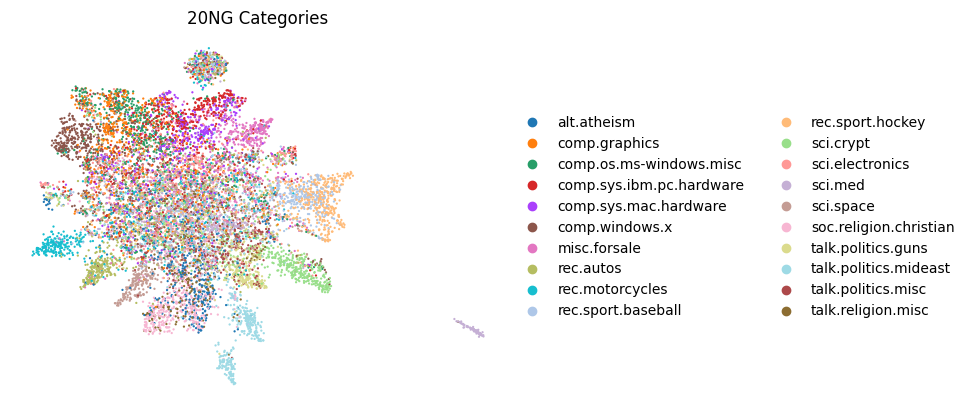

In [6]:
stop_words = set(stopwords.words("english"))

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
docs = data.data
labels = data.target
label_names = data.target_names

rows = []
for doc, label in tqdm(zip(docs, labels), total = len(labels)):
    words = doc.split()
    n_words = len(words)
    n_chars = len(doc)
    percent_stop = (sum(w.lower() in stop_words for w in words) / n_words) if n_words > 0 else 0.0

    rows.append({
        "n_words": n_words,
        "percent_stopwords": percent_stop,
        "n_chars": n_chars,
        "category": label_names[label],
    })

obs_df = pd.DataFrame(rows)

vectorizer = CountVectorizer(
    max_features=2000,  # vocabulary size
    stop_words="english",
)
X = vectorizer.fit_transform(docs)  # sparse matrix (n_docs × 2000 words)
vocab = vectorizer.get_feature_names_out()

adata = ad.AnnData(X)
adata.var_names = vocab
adata.obs = obs_df.copy()

sc.pp.normalize_total(adata) # library-size normalize
sc.pp.log1p(adata) # log transform
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var["highly_variable"]]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="category",
    title="20NG Categories",
    frameon=False,
)

## Let's regroup some categories together to make the UMAP more lisible

| New Broader Category           | Assigned Original Newsgroups                                   |
| ------------------------------ | -------------------------------------------------------------- |
| 1. Religion & Spirituality     | alt.atheism, soc.religion.christian, talk.religion.misc        |
| 2. Computers – OS & Graphics   | comp.os.ms-windows.misc, comp.windows.x, comp.sys.mac.hardware, comp.graphics  |
| 3. Computers – Hardware        | comp.sys.ibm.pc.hardware, sci.electronics                      |
| 4. Cryptography & Security     | sci.crypt                                                      |
| 5. Automobiles                 | rec.autos, rec.motorcycles                                     |
| 6. Sports                      | rec.sport.baseball, rec.sport.hockey                           |
| 7. Science & Medicine          | sci.space, sci.med                                             |
| 8. Politics                    | talk.politics.misc, talk.politics.guns, talk.politics.mideast  |
| 9. Marketplace / For Sale     | misc.forsale                                                   |

/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


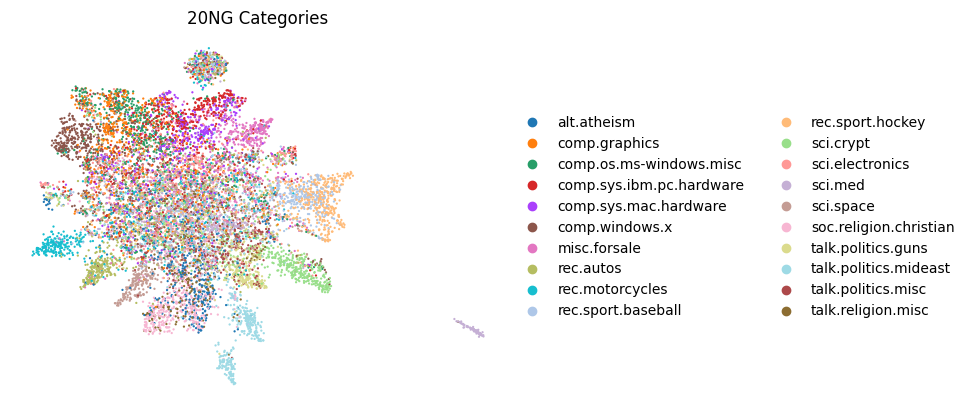

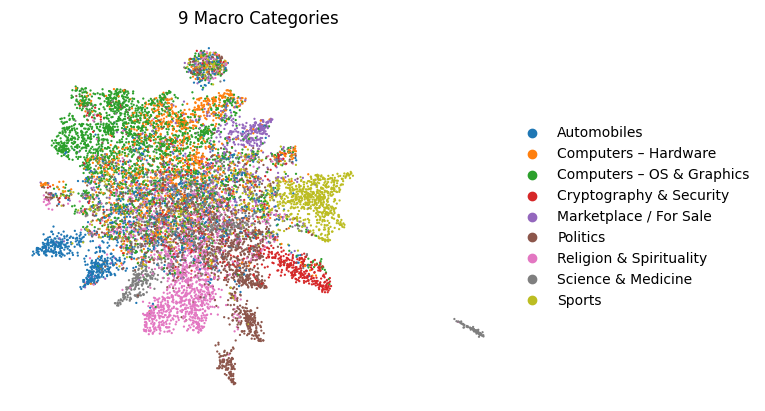

In [3]:
macro_mapping = {
    "alt.atheism": "Religion & Spirituality",
    "soc.religion.christian": "Religion & Spirituality",
    "talk.religion.misc": "Religion & Spirituality",

    "comp.graphics": "Computers – OS & Graphics",
    "comp.os.ms-windows.misc": "Computers – OS & Graphics",
    "comp.windows.x": "Computers – OS & Graphics",
    "comp.sys.mac.hardware": "Computers – OS & Graphics",

    "comp.sys.ibm.pc.hardware": "Computers – Hardware",
    "sci.electronics": "Computers – Hardware",

    "sci.crypt": "Cryptography & Security",

    "rec.autos": "Automobiles",
    "rec.motorcycles": "Automobiles",

    "rec.sport.baseball": "Sports",
    "rec.sport.hockey": "Sports",

    "sci.space": "Science & Medicine",
    "sci.med": "Science & Medicine",

    "talk.politics.misc": "Politics",
    "talk.politics.guns": "Politics",
    "talk.politics.mideast": "Politics",

    "misc.forsale": "Marketplace / For Sale",
}

adata = ad.AnnData(X)
adata.var_names = vocab
adata.obs = obs_df.copy()

adata.obs["macro_category"] = adata.obs["category"].map(macro_mapping)

sc.pp.normalize_total(adata) # library-size normalize
sc.pp.log1p(adata) # log transform
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var["highly_variable"]]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# UMAP embedding
sc.tl.umap(adata)

# UMAP colored by original 20 categories
sc.pl.umap(
    adata,
    color="category",
    title="20NG Categories",
    frameon=False,
)

# UMAP colored by macro-categories (9 broad groups)
sc.pl.umap(
    adata,
    color="macro_category",
    title="9 Macro Categories",
    frameon=False,
)



# Comparison of the two datasets: AnnData and NewsGroups

In [9]:
import pandas as pd
import scanpy as sc

# Load anndata 
anndata_bio = sc.read_h5ad("/Users/miguelcastells/Desktop/DTU courses/02456 Deep Learning/project/data/pbmc3k_processed.h5ad")
anndata_text = adata.copy()

# Copy the observations
df_bio = anndata_bio.obs.copy()
df_text = anndata_text.obs.copy()

# Only numeric for analysis
df_bio_num = df_bio.select_dtypes(include="number")
df_text_num = df_text.select_dtypes(include="number")

def summarize(df):
    return pd.DataFrame({
        "mean": df.mean(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "median": df.median()
    })

summary_bio = summarize(df_bio_num)
summary_text = summarize(df_text_num)

# COncatenate for visualization
comparison = pd.concat(
    {
        "Real_AnnData": summary_bio,
        "Text_AnnData_like": summary_text
    },
    axis=1
)

# Number of samples and categories
n_samples_bio = anndata_bio.n_obs
n_samples_text = anndata_text.n_obs

n_categories_bio = df_bio["louvain"].nunique() 
n_categories_text = df_text["category"].nunique()

# Print results
print("Number of samples:")
print(f"Bio AnnData:  {n_samples_bio}")
print(f"Text AnnData: {n_samples_text}\n")

print("Number of categories:")
print(f"Bio categories:  {n_categories_bio}")
print(f"Text categories: {n_categories_text}\n")

print("Summary comparison (numeric columns only):")
display(comparison)


Number of samples:
Bio AnnData:  2638
Text AnnData: 11314

Number of categories:
Bio categories:  8
Text categories: 9

Summary comparison (numeric columns only):


/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/anndata/_io/h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(**{
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/anndata/_io/h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(**{


Real_AnnData                                               \
                          mean         std    min          max       median   
n_genes             850.086808  263.373564  212.0  2455.000000   820.000000   
percent_mito          0.021166    0.008431    0.0     0.049938     0.020107   
n_counts           2371.069092  990.158752  556.0  8875.000000  2213.000000   
n_words                    NaN         NaN    NaN          NaN          NaN   
percent_stopwords          NaN         NaN    NaN          NaN          NaN   
n_chars                    NaN         NaN    NaN          NaN          NaN   

                  Text_AnnData_like                                         
                               mean          std  min      max      median  
n_genes                         NaN          NaN  NaN      NaN         NaN  
percent_mito                    NaN          NaN  NaN      NaN         NaN  
n_counts                        NaN          NaN  NaN      NaN         NaN  
n_words                  185.827382   523.971647  0.0  11765.0   83.000000  
percent_stopwords          0.411375     0.122297  0.0      1.0    0.441176  
n_chars                 1218.135496  4038.256477  0.0  74878.0  491.000000

- $\sim$ x4 more samples in the text dataset
- $\sim$ x20 higher values for the percent_mito/stopwords
- n_counts/n_char: Less char on average but higher dispersion

# Remove useless data for final version of the dataset

In [ ]:
# Remove the old 20 category column
for col in [ "category"]:
    if col in adata.obs:
        del adata.obs[col]

# Rename macro_category to category
adata.obs = adata.obs.rename(columns={"macro_category": "category"})

# Update colors if present in .uns
if "macro_category_colors" in adata.uns:
    adata.uns["category_colors"] = adata.uns["macro_category_colors"]
    del adata.uns["macro_category_colors"]

adata.write("9NewsGroups_annData_like.h5ad")

# From one to multimodality on MIDAA: Format 20NewsGroup as ATAC dataset

For the scATAC-seq like dataset, we use Latent Dirichlet Allocation:
| Column (scATAC-seq)                                     | Column (text)       | Description                                                                                   |
| ------------------------------------------------------- | ------------------- | --------------------------------------------------------------------------------------------- |
| **n_peaks**                                             | `n_words`           | number of words in the document         |
| **percent_reads_in_peaks (FRiP)**                       | `percent_stopwords` | proportion of stopwords in the document  |
| **n_counts**                                            | `n_chars`           | Total characters in the document |
| **chromatin_topic** (LDA topic label or cisTopic topic) | `category`          | Document category                                   |



In [7]:
data = fetch_20newsgroups(
    subset="train",
    remove=("headers", "footers", "quotes")
)

docs = data.data
labels = data.target
label_names = np.array(data.target_names)

vectorizer = CountVectorizer(
    stop_words="english",
    max_features=5000      # number of "peaks" before topic modeling
)

X_counts = vectorizer.fit_transform(docs)

n_topics = 25   # analog of chromatin topics

lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method="batch",
    random_state=0
)

X_lda = lda.fit_transform(X_counts)    # shape = (n_docs, n_topics)
print("ATAC-like topic matrix:", X_lda.shape)

obs_df = pd.DataFrame({
    "category": label_names[labels],   # your 9 categories
})

var_df = pd.DataFrame(index=[f"topic_{i}" for i in range(n_topics)])

adata_atac = ad.AnnData(
    X_lda,
    obs=obs_df,
    var=var_df
)

adata_atac.uns["topics"] = np.arange(n_topics)

adata.write("9ng_atac_like.h5ad")


ATAC-like topic matrix: (11314, 25)


/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


# Pipeline for raw data

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.auto import tqdm
from nltk.corpus import stopwords

# -----------------------------
# 1. Charger le dataset brut
# -----------------------------
stop_words = set(stopwords.words("english"))

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
docs = data.data
labels = data.target
label_names = data.target_names

# -----------------------------
# 2. Créer obs_df (métadonnées)
# -----------------------------
rows = []
for doc, label in tqdm(zip(docs, labels), total=len(labels)):
    words = doc.split()
    n_words = len(words)
    percent_stop = (sum(w.lower() in stop_words for w in words) / n_words) if n_words > 0 else 0.0

    rows.append({
        "n_words": n_words,
        "percent_stopwords": percent_stop,
        "category": label_names[label],
    })

obs_df = pd.DataFrame(rows)

# -----------------------------
# 3. Compter les mots (comptes bruts)
# -----------------------------
vectorizer = CountVectorizer(
    max_features=2000,      # vocabulaire limité
    stop_words="english",
)

X_raw = vectorizer.fit_transform(docs)   # ⚠ sparse matrix, raw counts (integers)
vocab = vectorizer.get_feature_names_out()

# -----------------------------
# 4. Construire AnnData
# -----------------------------
adata = ad.AnnData(X_raw)
adata.var_names = vocab
adata.obs = obs_df.copy()

# -----------------------------
# 5. Ajouter une colonne n_counts (somme des mots du document)
# -----------------------------
adata.obs["n_counts"] = np.array(X_raw.sum(axis=1)).flatten()

macro_mapping = {
    "alt.atheism": "Religion & Spirituality",
    "soc.religion.christian": "Religion & Spirituality",
    "talk.religion.misc": "Religion & Spirituality",

    "comp.graphics": "Computers – OS & Graphics",
    "comp.os.ms-windows.misc": "Computers – OS & Graphics",
    "comp.windows.x": "Computers – OS & Graphics",
    "comp.sys.mac.hardware": "Computers – OS & Graphics",

    "comp.sys.ibm.pc.hardware": "Computers – Hardware",
    "sci.electronics": "Computers – Hardware",

    "sci.crypt": "Cryptography & Security",

    "rec.autos": "Automobiles",
    "rec.motorcycles": "Automobiles",

    "rec.sport.baseball": "Sports",
    "rec.sport.hockey": "Sports",

    "sci.space": "Science & Medicine",
    "sci.med": "Science & Medicine",

    "talk.politics.misc": "Politics",
    "talk.politics.guns": "Politics",
    "talk.politics.mideast": "Politics",

    "misc.forsale": "Marketplace / For Sale",
}

adata.obs["macro_category"] = adata.obs["category"].map(macro_mapping)

for col in [ "category"]:
    if col in adata.obs:
        del adata.obs[col]

# Rename macro_category to category
adata.obs = adata.obs.rename(columns={"macro_category": "category"})

# Update colors if present in .uns
if "macro_category_colors" in adata.uns:
    adata.uns["category_colors"] = adata.uns["macro_category_colors"]
    del adata.uns["macro_category_colors"]

adata.write("test_9NG.h5ad")

# -----------------------------
# 6. (PAS DE normalisation_total, PAS DE log1p, PAS DE scaling)
# -----------------------------
# Important : ADATA = COMPTES BRUTS → parfait pour NB


100%|██████████| 11314/11314 [00:00<00:00, 53480.72it/s]
/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


# Pipeline for TF-IFD representation: Specific to text

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
import anndata as ad

# 1. Build TF-IDF matrix
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words="english",
)
X_tfidf = vectorizer.fit_transform(docs)   # sparse (n_docs × 2000)

# 2. Convert sparse → dense (safe if 2000 features)
X_tfidf = X_tfidf.toarray()

# 3. OPTIONAL: Clip extreme values to avoid huge gradients
X_tfidf = np.clip(X_tfidf, 0, 10)

# 4. Standardize (CRITICAL for Gaussian likelihood!)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_tfidf)    # distribution ~ Gaussian

# 5. Create AnnData
adata = ad.AnnData(X_scaled)
adata.var_names = vectorizer.get_feature_names_out()

adata.obs = obs_df.copy()

# -----------------------------
# 5. Ajouter une colonne n_counts (somme des mots du document)
# -----------------------------
adata.obs["n_counts"] = np.array(X_raw.sum(axis=1)).flatten()

macro_mapping = {
    "alt.atheism": "Religion & Spirituality",
    "soc.religion.christian": "Religion & Spirituality",
    "talk.religion.misc": "Religion & Spirituality",

    "comp.graphics": "Computers – OS & Graphics",
    "comp.os.ms-windows.misc": "Computers – OS & Graphics",
    "comp.windows.x": "Computers – OS & Graphics",
    "comp.sys.mac.hardware": "Computers – OS & Graphics",

    "comp.sys.ibm.pc.hardware": "Computers – Hardware",
    "sci.electronics": "Computers – Hardware",

    "sci.crypt": "Cryptography & Security",

    "rec.autos": "Automobiles",
    "rec.motorcycles": "Automobiles",

    "rec.sport.baseball": "Sports",
    "rec.sport.hockey": "Sports",

    "sci.space": "Science & Medicine",
    "sci.med": "Science & Medicine",

    "talk.politics.misc": "Politics",
    "talk.politics.guns": "Politics",
    "talk.politics.mideast": "Politics",

    "misc.forsale": "Marketplace / For Sale",
}

adata.obs["macro_category"] = adata.obs["category"].map(macro_mapping)

for col in [ "category"]:
    if col in adata.obs:
        del adata.obs[col]

# Rename macro_category to category
adata.obs = adata.obs.rename(columns={"macro_category": "category"})

# Update colors if present in .uns
if "macro_category_colors" in adata.uns:
    adata.uns["category_colors"] = adata.uns["macro_category_colors"]
    del adata.uns["macro_category_colors"]

adata.write("TF_IFD_9NG.h5ad")

/opt/anaconda3/envs/MIDAA/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
